Processing Phys-only
Processing NN+solver
Processing NN+phys+reg


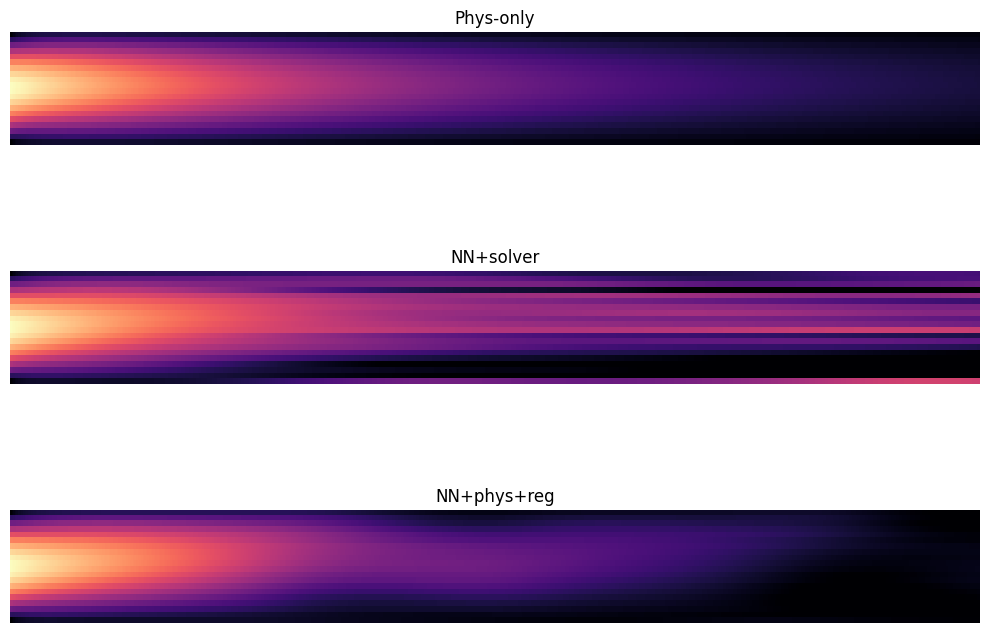

In [20]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae.advdif.model import VAE

device = "cpu"
idx = 78
showlen = 600
datadir = './data/advdif'
dataname = 'test'
data_test = np.load(f'{datadir}/data_{dataname}.npy')

variant_dirs = {
    "Phys-only": "./out_advdif_physonly/",
    "NN+solver": "./out_advdif_nnonly1/",
    "NN+phys+reg": "./out_advdif_physnn/",
}

outputs = {}

for name, modeldir in variant_dirs.items():
    print(f"Processing {name}")
    with open(f'{modeldir}/args.json', 'r') as f:
        args = json.load(f)

    model = VAE(args).to(device)
    model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
    model.eval()

    dim_x = args['dim_x']
    dim_t = args['dim_t']

    data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).view(-1, dim_x, dim_t)
    with torch.no_grad():
        z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
        z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat)

    model.len_intg = (1000 - 1) * model.intg_lev + 1
    model.t_intg = torch.linspace(0.0, model.dt_intg * (model.len_intg - 1), model.len_intg)

    data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).view(-1, dim_x, data_test.shape[-1])
    with torch.no_grad():
        init_y = data_tensor[:, :, 0].clone()
        x_full, *_ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

    outputs[name] = x_full[idx, :, :showlen].detach().cpu().numpy()

# Plotting all
vmax = data_test[idx].max()
kwargs = {'vmin': 0.0, 'vmax': vmax, 'aspect': 3.5, 'cmap': 'magma', 'interpolation': 'none'}

fig, axs = plt.subplots(len(outputs), 1, figsize=(10, 8))
for ax, (name, img) in zip(axs, outputs.items()):
    ax.imshow(img, **kwargs)
    ax.set_title(name, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()


Processing Phys-only
Processing NN+solver
Processing NN+phys+reg


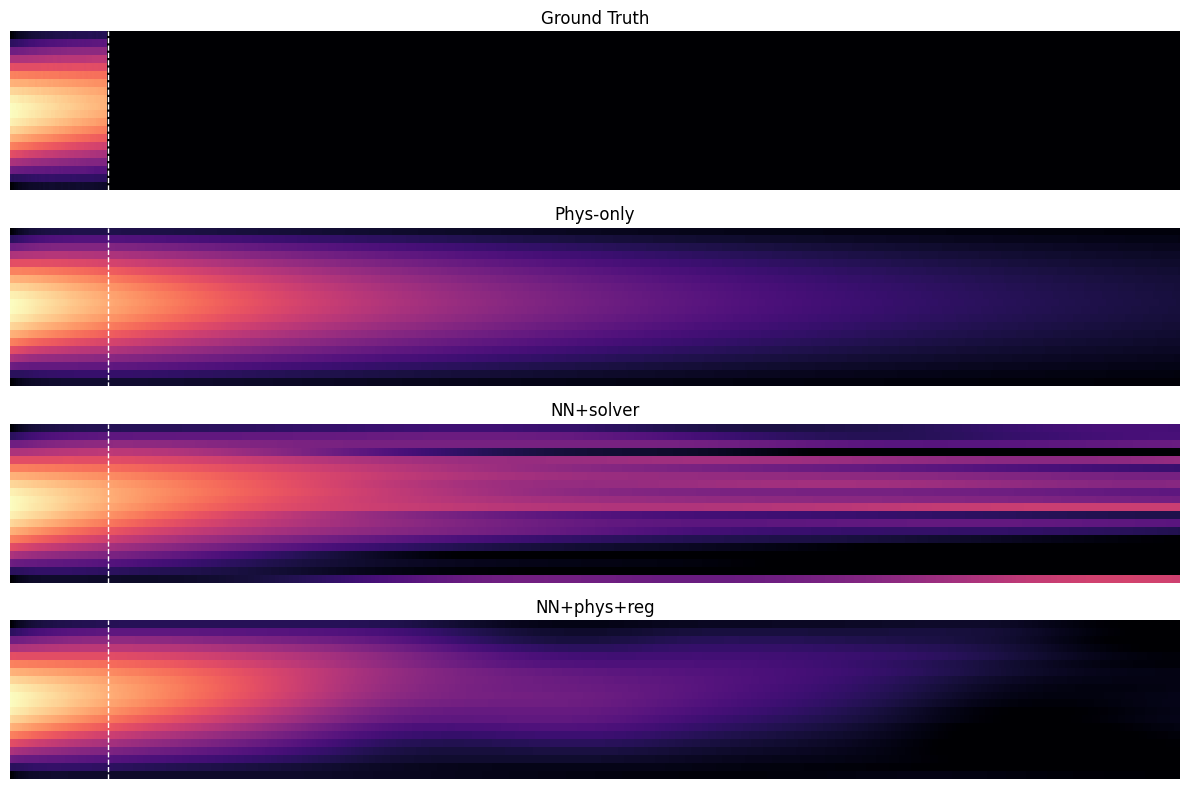

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae.advdif.model import VAE

device = "cpu"
idx = 78
showlen = 600
datadir = './data/advdif'
dataname = 'test'
data_test = np.load(f'{datadir}/data_{dataname}.npy')

variant_dirs = {
#     "Ground Truth": None,
    "Phys-only": "./out_advdif_physonly/",
    "NN+solver": "./out_advdif_nnonly1/",
    "NN+phys+reg": "./out_advdif_physnn/",
}

outputs = {}

# Ground truth (just copy the available part into a canvas of length showlen)
dim_t = data_test.shape[-1]
truth_img = np.zeros((data_test.shape[1], showlen))
truth_img[:, :dim_t] = data_test[idx, :, :dim_t]
outputs["Ground Truth"] = truth_img

# Models
for name, modeldir in variant_dirs.items():
    if modeldir is None:
        continue  # Ground truth already handled

    print(f"Processing {name}")
    with open(f'{modeldir}/args.json', 'r') as f:
        args = json.load(f)

    model = VAE(args).to(device)
    model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
    model.eval()

    dim_x = args['dim_x']
    dim_t = args['dim_t']
    dt = args['dt']

    data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).view(-1, dim_x, dim_t)
    with torch.no_grad():
        z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
        z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat)

    model.len_intg = (1000 - 1) * model.intg_lev + 1
    model.t_intg = torch.linspace(0.0, model.dt_intg * (model.len_intg - 1), model.len_intg)

    data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).view(-1, dim_x, data_test.shape[-1])
    with torch.no_grad():
        init_y = data_tensor[:, :, 0].clone()
        x_full, *_ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

    outputs[name] = x_full[idx, :, :showlen].detach().cpu().numpy()

# Plotting
vmax = data_test[idx].max()
kwargs = {'vmin': 0.0, 'vmax': vmax, 'aspect': 'auto', 'cmap': 'magma', 'interpolation': 'none'}
t_boundary = int(1.0 / dt)

fig, axs = plt.subplots(len(outputs), 1, figsize=(12, 8))
for ax, (name, img) in zip(axs, outputs.items()):
    ax.imshow(img, **kwargs)
    ax.axvline(x=t_boundary, color='white', linestyle='--', linewidth=1)
    ax.set_title(name, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig("figure4_like_plot.png", dpi=300, bbox_inches='tight')
plt.show()


Processing Phys-only
Processing NN+solver
Processing NN+phys+reg


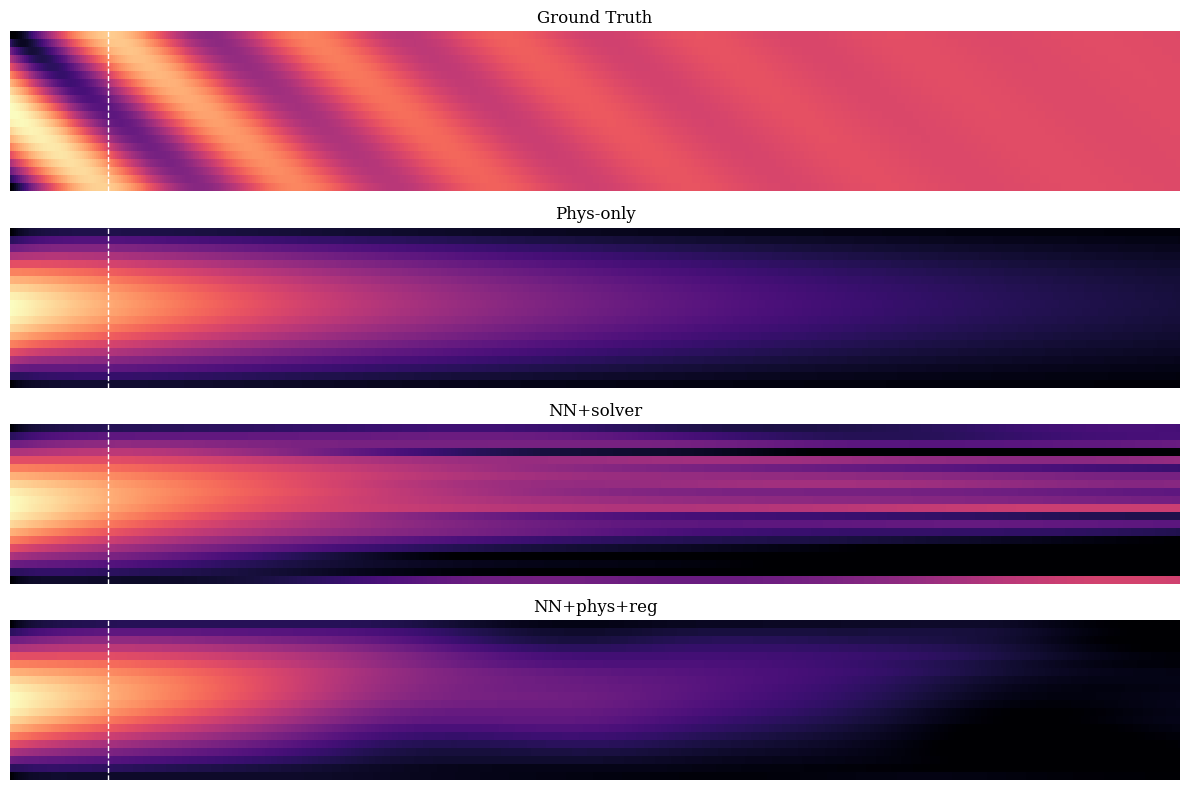

In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae.advdif.model import VAE

device = "cpu"
idx = 78
showlen = 600
datadir = './data/advdif'
dataname = 'test'
data_test = np.load(f'{datadir}/data_{dataname}.npy')

variant_dirs = {
    "Phys-only": "./out_advdif_physonly/",
    "NN+solver": "./out_advdif_nnonly1/",
    "NN+phys+reg": "./out_advdif_physnn/",
}

# ---- Numerical simulation for Ground Truth extrapolation ----
def simulate_advection_diffusion(u0, dx, dt, nt, alpha=0.05, beta=1.0):
    nx = len(u0)
    u_all = np.zeros((nx, nt))
    u_all[:, 0] = u0
    for t in range(1, nt):
        u = u_all[:, t - 1]
        u_xx = np.roll(u, -1) - 2*u + np.roll(u, 1)
        u_x = np.roll(u, -1) - np.roll(u, 1)
        u_all[:, t] = u + dt * (alpha * u_xx / dx**2 - beta * u_x / (2*dx))
    return u_all

# ---- Load common args (from any model variant) ----
with open('./out_advdif_physnn/args.json', 'r') as f:
    ref_args = json.load(f)
dim_x = ref_args['dim_x']
dx = ref_args['dx']
dt = ref_args['dt']

# ---- Prepare output images ----
outputs = {}

# Simulated Ground Truth
u0 = data_test[idx, :, 0]
sim_truth = simulate_advection_diffusion(u0, dx, dt, showlen)
outputs["Ground Truth"] = sim_truth

# ---- Process each model variant ----
for name, modeldir in variant_dirs.items():
    print(f"Processing {name}")
    with open(f'{modeldir}/args.json', 'r') as f:
        args = json.load(f)

    model = VAE(args).to(device)
    model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
    model.eval()

    data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).view(-1, dim_x, args['dim_t'])
    with torch.no_grad():
        z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
        z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat)

    model.len_intg = (1000 - 1) * model.intg_lev + 1
    model.t_intg = torch.linspace(0.0, model.dt_intg * (model.len_intg - 1), model.len_intg)

    with torch.no_grad():
        init_y = data_tensor[:, :, 0].clone()
        x_full, *_ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

    outputs[name] = x_full[idx, :, :showlen].detach().cpu().numpy()

# ---- Plot all images ----
vmax = data_test[idx].max()
kwargs = {'vmin': 0.0, 'vmax': vmax, 'aspect': 'auto', 'cmap': 'magma', 'interpolation': 'none'}
t_boundary = int(1.0 / dt)

fig, axs = plt.subplots(len(outputs), 1, figsize=(12, 8))
for ax, (name, img) in zip(axs, outputs.items()):
    ax.imshow(img, **kwargs)
    ax.axvline(x=t_boundary, color='white', linestyle='--', linewidth=1)
    ax.set_title(name, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig("figure4_like_plot.png", dpi=300, bbox_inches='tight')
plt.show()


In [4]:
import os
print(os.listdir('./data/advdif'))


['generate.py', 'makedata.sh', 'args_train.json', 'data_train.npy', 'true_params_train.txt', 'args_valid.json', 'data_valid.npy', 'true_params_valid.txt', 'args_test.json', 'data_test.npy', 'true_params_test.txt']


In [5]:
import numpy as np

params = np.loadtxt('./data/advdif/true_params_test.txt')
a, b, c = params[78]  # idx = 78 from your code
print(f"a = {a}, b = {b}, c = {c}")


a = 0.7120298578, b = 0.06800617158, c = 0.08716960013


In [25]:
print(params[78] )

[0.71202986 0.06800617 0.0871696 ]


In [6]:
def solve_advdiff(T0, a, b, dt, nt, dx):
    nx = T0.shape[0]
    T = np.zeros((nx, nt))
    T[:, 0] = T0.copy()
    for t in range(1, nt):
        T[1:-1, t] = T[1:-1, t-1] + dt * (
            a * (T[2:, t-1] - 2 * T[1:-1, t-1] + T[:-2, t-1]) / dx**2
            - b * (T[2:, t-1] - T[:-2, t-1]) / (2 * dx)
        )
        T[0, t] = T[-1, t] = 0  # Dirichlet boundary conditions
    return T


In [8]:
print(f"a * dt / dx^2 = {a * dt / dx**2}")
print(f"b * dt / dx   = {b * dt / dx}")

T0 = data_test[78, :, 0]  # Initial spatial profile
nx = T0.shape[0]
smax = 1.0  # assumed from paper
dx = smax / (nx - 1)
dt = 0.02
nt = 600  # same as showlen

truth_img = solve_advdiff(T0, a, b, dt, nt, dx)


a * dt / dx^2 = 5.140855573316001
b * dt / dx   = 0.025842345200399998


/tmp/ipykernel_3636629/1202275776.py:7: RuntimeWarning: overflow encountered in divide
  a * (T[2:, t-1] - 2 * T[1:-1, t-1] + T[:-2, t-1]) / dx**2
/tmp/ipykernel_3636629/1202275776.py:8: RuntimeWarning: invalid value encountered in subtract
  - b * (T[2:, t-1] - T[:-2, t-1]) / (2 * dx)
/tmp/ipykernel_3636629/1202275776.py:7: RuntimeWarning: invalid value encountered in subtract
  a * (T[2:, t-1] - 2 * T[1:-1, t-1] + T[:-2, t-1]) / dx**2
/tmp/ipykernel_3636629/1202275776.py:6: RuntimeWarning: invalid value encountered in add
  T[1:-1, t] = T[1:-1, t-1] + dt * (


In [9]:
# Spatial grid
nx = T0.shape[0]
smax = 1.0
dx = smax / (nx - 1)

# Compute stable dt
dt = 0.5 * dx**2 / a
nt = int(12 / dt)
print(f"Using dt={dt:.5f}, nt={nt} for stable simulation")

# Run stable simulation
truth_img = solve_advdiff(T0, a, b, dt, nt, dx)


Using dt=0.00195, nt=6169 for stable simulation


Processing Phys-only
Processing NN+solver
Processing NN+phys+reg


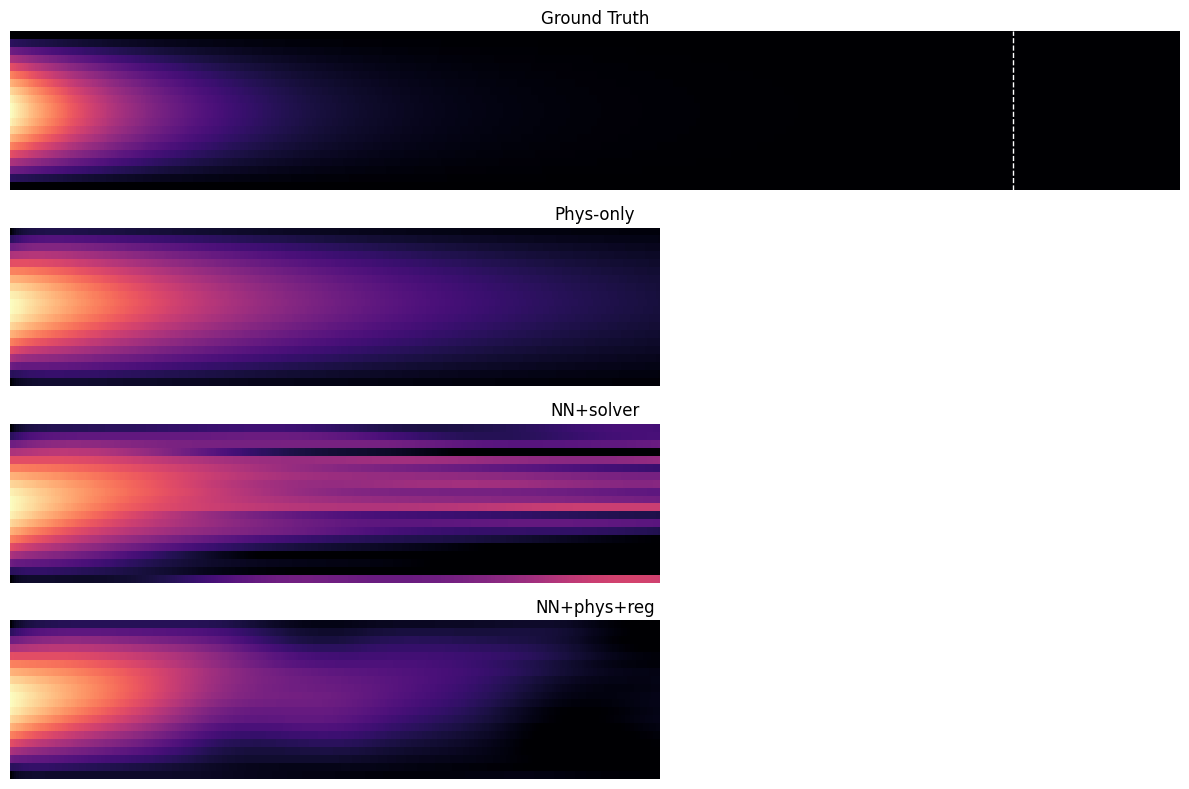

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae.advdif.model import VAE

device = "cpu"
idx = 78
showlen = 600
datadir = './data/advdif'
dataname = 'test'
data_test = np.load(f'{datadir}/data_{dataname}.npy')
params_test = np.loadtxt(f'{datadir}/true_params_{dataname}.txt')
a, b, c = params_test[idx]

# Solve stable advection-diffusion PDE
def solve_advdiff(T0, a, b, dt, nt, dx):
    nx = T0.shape[0]
    T = np.zeros((nx, nt))
    T[:, 0] = T0.copy()
    for t in range(1, nt):
        lap = (T[2:, t-1] - 2 * T[1:-1, t-1] + T[:-2, t-1]) / dx**2
        adv = (T[2:, t-1] - T[:-2, t-1]) / (2 * dx)
        T[1:-1, t] = T[1:-1, t-1] + dt * (a * lap - b * adv)
        T[0, t] = T[-1, t] = 0  # Dirichlet BCs
    return T

# Calculate stable dt and nt
nx = data_test.shape[1]
smax = 1.0
dx = smax / (nx - 1)
dt = 0.5 * dx**2 / a
nt = showlen  # You can change this to int(12 / dt) for full 12s sim

# Initial condition from data
T0 = data_test[idx, :, 0]
truth_img = solve_advdiff(T0, a, b, dt, nt, dx)

outputs = {"Ground Truth": truth_img}

# Models to compare
variant_dirs = {
    "Phys-only": "./out_advdif_physonly/",
    "NN+solver": "./out_advdif_nnonly1/",
    "NN+phys+reg": "./out_advdif_physnn/",
}

# Model outputs
for name, modeldir in variant_dirs.items():
    print(f"Processing {name}")
    with open(f'{modeldir}/args.json', 'r') as f:
        args = json.load(f)

    model = VAE(args).to(device)
    model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
    model.eval()

    dim_x = args['dim_x']
    dim_t = args['dim_t']
    model.len_intg = showlen  # override integration length
    model.t_intg = torch.linspace(0.0, args['dt'] * (showlen - 1), showlen)

    data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).view(-1, dim_x, dim_t)
    with torch.no_grad():
        z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
        z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat)
        init_y = data_tensor[:, :, 0].clone()
        x_full, *_ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

    outputs[name] = x_full[idx, :, :showlen].detach().cpu().numpy()

# Plotting
vmax = np.nanmax(truth_img)
kwargs = {'vmin': 0.0, 'vmax': vmax, 'aspect': 'auto', 'cmap': 'magma', 'interpolation': 'none'}
t_boundary = int(1.0 / dt)  # boundary between reconstruction and extrapolation

fig, axs = plt.subplots(len(outputs), 1, figsize=(12, 8))
for ax, (name, img) in zip(axs, outputs.items()):
    ax.imshow(img, **kwargs)
    ax.axvline(x=t_boundary, color='white', linestyle='--', linewidth=1)
    ax.set_title(name, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig("figure4_like_plot.png", dpi=300, bbox_inches='tight')
plt.show()


Processing Phys-only
Processing NN+solver
Processing NN+phys+reg


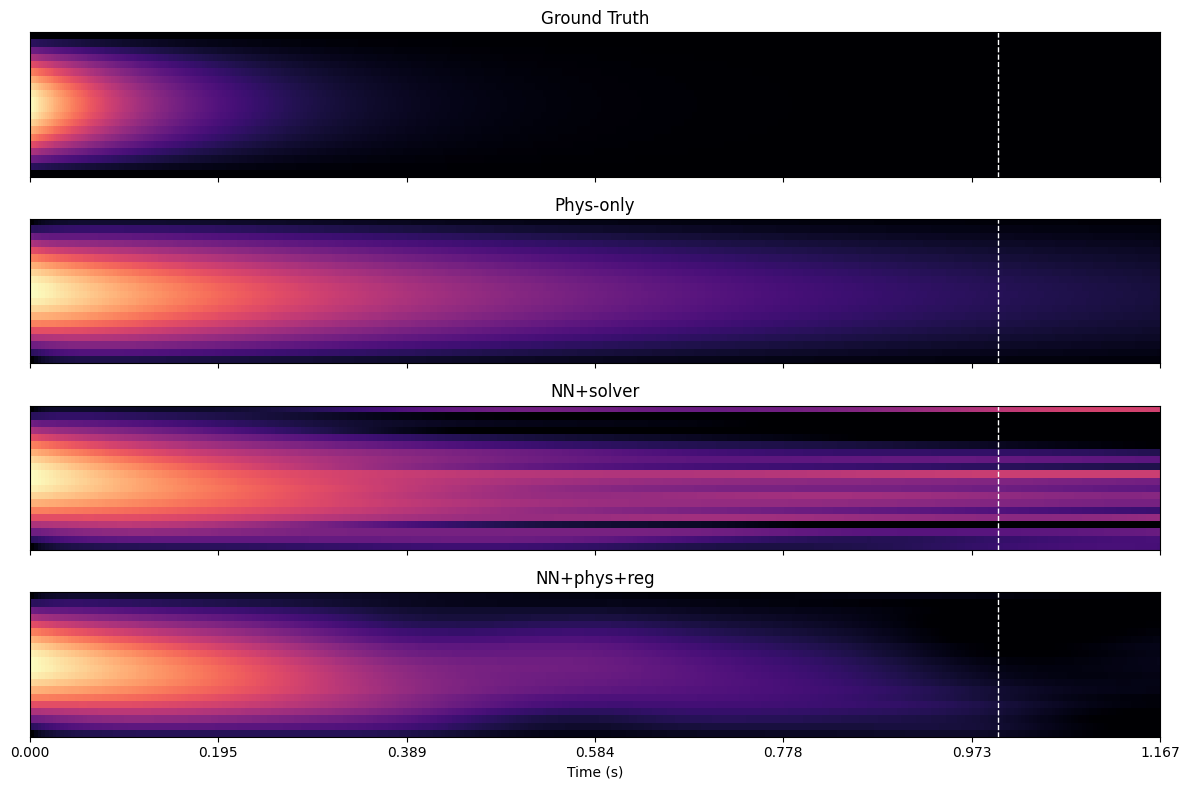

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae.advdif.model import VAE

# Settings
device = "cpu"
idx = 78
showlen = 600
datadir = './data/advdif'
dataname = 'test'

# Load data and params
data_test = np.load(f'{datadir}/data_{dataname}.npy')
params_test = np.loadtxt(f'{datadir}/true_params_{dataname}.txt')
a, b, c = params_test[idx]

# Grid
nx = data_test.shape[1]
smax = 1.0
dx = smax / (nx - 1)
dt = 0.5 * dx**2 / a
nt = showlen
T_end = dt * nt

# Initial condition
T0 = data_test[idx, :, 0].copy()

def solve_advdiff(T0, a, b, dt, nt, dx):
    nx = T0.shape[0]
    T = np.zeros((nx, nt))
    T[:, 0] = T0
    for t in range(1, nt):
        lap = (T[2:, t-1] - 2 * T[1:-1, t-1] + T[:-2, t-1]) / dx**2
        adv = (T[2:, t-1] - T[:-2, t-1]) / (2 * dx)
        T[1:-1, t] = T[1:-1, t-1] + dt * (a * lap - b * adv)
        T[0, t] = T[-1, t] = 0
    return T

truth_img = solve_advdiff(T0, a, b, dt, nt, dx)
outputs = {"Ground Truth": truth_img}

variant_dirs = {
    "Phys-only": "./out_advdif_physonly/",
    "NN+solver": "./out_advdif_nnonly1/",
    "NN+phys+reg": "./out_advdif_physnn/",
}

# Load VAE outputs
for name, modeldir in variant_dirs.items():
    print(f"Processing {name}")
    with open(f'{modeldir}/args.json', 'r') as f:
        args = json.load(f)

    model = VAE(args).to(device)
    model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
    model.eval()

    dim_x = args['dim_x']
    dim_t = args['dim_t']
    model.len_intg = showlen
    model.t_intg = torch.linspace(0.0, args['dt'] * (showlen - 1), showlen)

    data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).view(-1, dim_x, dim_t)
    with torch.no_grad():
        z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
        z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat)
        init_y = data_tensor[:, :, 0].clone()
        x_full, *_ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

    outputs[name] = x_full[idx, :, :showlen].detach().cpu().numpy()

# Plot settings
vmax = np.nanmax(truth_img)
t_boundary = 1.0  # seconds
t_boundary_idx = int(t_boundary / dt)
extent = [0, T_end, 0, 1.0]  # time from 0 to T_end (sec), space from 0 to 1

fig, axs = plt.subplots(len(outputs), 1, figsize=(12, 8), sharex=True,
                        gridspec_kw={'height_ratios': [1]*len(outputs)})

for i, (name, img) in enumerate(outputs.items()):
    im = axs[i].imshow(img, vmin=0.0, vmax=vmax, aspect='auto', cmap='magma',
                       interpolation='none', extent=extent, origin='lower')
    axs[i].axvline(x=t_boundary, color='white', linestyle='--', linewidth=1)
    axs[i].set_title(name, fontsize=12)
    axs[i].set_yticks([])
    axs[i].set_ylabel("")

# Show time only on bottom
axs[-1].set_xlabel("Time (s)")
axs[-1].set_xticks(np.linspace(0, T_end, 7))
axs[-1].tick_params(axis='x', labelsize=10)

# Save and show
plt.tight_layout()
plt.savefig("figure4_like_replica_final.png", dpi=300, bbox_inches='tight')
plt.show()


Processing Phys-only
Processing NN+solver
Processing NN+phys+reg


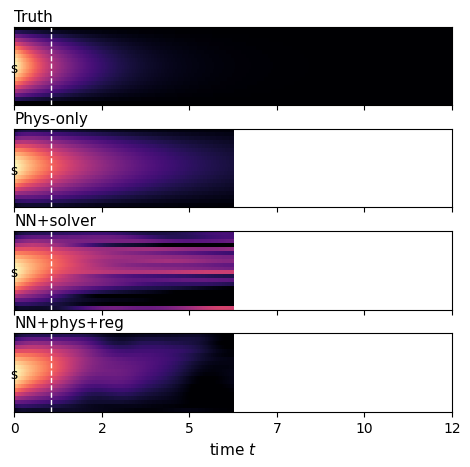

In [20]:
# import json
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# from physvae.advdif.model import VAE

# device = "cpu"
# idx = 78
# showlen = 600
# datadir = './data/advdif'
# dataname = 'test'
# data_test = np.load(f'{datadir}/data_{dataname}.npy')
# params_test = np.loadtxt(f'{datadir}/true_params_{dataname}.txt')
# a, b, c = params_test[idx]

# # --- Solve stable advection-diffusion PDE for Ground Truth ---
# def solve_advdiff(T0, a, b, dt, nt, dx):
#     nx = T0.shape[0]
#     T = np.zeros((nx, nt))
#     T[:, 0] = T0.copy()
#     for t in range(1, nt):
#         lap = (T[2:, t-1] - 2 * T[1:-1, t-1] + T[:-2, t-1]) / dx**2
#         adv = (T[2:, t-1] - T[:-2, t-1]) / (2 * dx)
#         T[1:-1, t] = T[1:-1, t-1] + dt * (a * lap - b * adv)
#         T[0, t] = T[-1, t] = 0
#     return T

# nx = data_test.shape[1]
# dx = 1.0 / (nx - 1)
# dt = 0.5 * dx**2 / a
# nt = showlen
# T0 = data_test[idx, :, 0]
# truth_img = solve_advdiff(T0, a, b, dt, nt, dx)

# outputs = {"Truth": truth_img}

# # --- Models to compare ---
# variant_dirs = {
#     "Phys-only": "./out_advdif_physonly/",
#     "NN+solver": "./out_advdif_nnonly1/",
#     "NN+phys+reg": "./out_advdif_physnn/",
# }

# for name, modeldir in variant_dirs.items():
#     print(f"Processing {name}")
#     with open(f'{modeldir}/args.json', 'r') as f:
#         args = json.load(f)

#     model = VAE(args).to(device)
#     model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
#     model.eval()

#     dim_x = args['dim_x']
#     dim_t = args['dim_t']
#     model.len_intg = showlen
#     model.t_intg = torch.linspace(0.0, args['dt'] * (showlen - 1), showlen)

#     data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).view(-1, dim_x, dim_t)
#     with torch.no_grad():
#         z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
#         z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat)
#         init_y = data_tensor[:, :, 0].clone()
#         x_full, *_ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

#     outputs[name] = x_full[idx, :, :showlen].detach().cpu().numpy()

# # --- Plotting ---
# vmax = np.nanmax(truth_img)
# kwargs = {'vmin': 0.0, 'vmax': vmax, 'aspect': 'auto', 'cmap': 'magma', 'interpolation': 'none'}

# fig, axs = plt.subplots(len(outputs), 1, figsize=(6, 5), sharex=True)

# t_end = args['dt'] * (showlen - 1)
# t_ticks = np.linspace(0, t_end, 6)
# t_tick_labels = [f"{t:.0f}" for t in t_ticks]
# t_boundary_time = 1.0
# t_boundary = int(t_boundary_time / args['dt'])

# for i, (name, img) in enumerate(outputs.items()):
#     ax = axs[i]
#     im = ax.imshow(img, **kwargs)
#     ax.axvline(x=t_boundary, color='white', linestyle='--', linewidth=1)
#     ax.set_yticks([])
#     ax.text(-5, img.shape[0]//2, "s", fontsize=10, va='center')
#     ax.set_title(name, fontsize=11, loc='left', pad=4)
#     if i == len(outputs) - 1:
#         ax.set_xticks(np.linspace(0, showlen-1, 6))
#         ax.set_xticklabels(t_tick_labels)
#         ax.set_xlabel("time $t$", fontsize=11)
#     else:
#         ax.set_xticks([])

# fig.subplots_adjust(left=0.12, right=0.85, hspace=0.3)
# plt.savefig("figure4_replicated.png", dpi=300, bbox_inches='tight')
# plt.show()


Processing Phys-only
Processing NN+solver
Processing NN+phys+reg


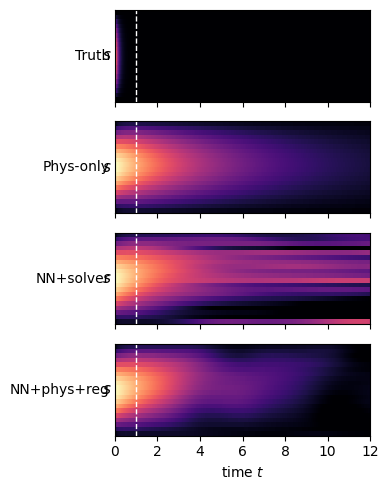

In [23]:
# import json
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# from physvae.advdif.model import VAE

# device = "cpu"
# idx = 78
# datadir = './data/advdif'
# dataname = 'test'
# data_test = np.load(f'{datadir}/data_{dataname}.npy')
# params_test = np.loadtxt(f'{datadir}/true_params_{dataname}.txt')
# a, b, c = params_test[idx]

# # PDE Solver for Ground Truth (stable scheme)
# def solve_advdiff(T0, a, b, dt, nt, dx):
#     nx = T0.shape[0]
#     T = np.zeros((nx, nt))
#     T[:, 0] = T0.copy()
#     for t in range(1, nt):
#         lap = (T[2:, t-1] - 2 * T[1:-1, t-1] + T[:-2, t-1]) / dx**2
#         adv = (T[2:, t-1] - T[:-2, t-1]) / (2 * dx)
#         T[1:-1, t] = T[1:-1, t-1] + dt * (a * lap - b * adv)
#         T[0, t] = T[-1, t] = 0  # Dirichlet BCs
#     return T

# # Stable dt and derived quantities
# nx = data_test.shape[1]
# smax = 1.0
# dx = smax / (nx - 1)
# dt = 0.5 * dx**2 / a  # stable CFL condition
# T_total = 12.0
# nt = int(T_total / dt)
# t = np.linspace(0, T_total, nt)
# t_boundary_time = 1.0
# t_boundary = int(t_boundary_time / dt)

# # Ground truth simulation
# T0 = data_test[idx, :, 0]
# truth_img = solve_advdiff(T0, a, b, dt, nt, dx)
# outputs = {"Truth": truth_img}

# # Model output variants
# variant_dirs = {
#     "Phys-only": "./out_advdif_physonly/",
#     "NN+solver": "./out_advdif_nnonly1/",
#     "NN+phys+reg": "./out_advdif_physnn/",
# }

# for name, modeldir in variant_dirs.items():
#     print(f"Processing {name}")
#     with open(f'{modeldir}/args.json', 'r') as f:
#         args = json.load(f)

#     model = VAE(args).to(device)
#     model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
#     model.eval()

#     dim_x = args['dim_x']
#     dim_t = args['dim_t']
#     model.len_intg = nt
#     model.t_intg = torch.linspace(0.0, dt * (nt - 1), nt)

#     data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).view(-1, dim_x, dim_t)
#     with torch.no_grad():
#         z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
#         z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat)
#         init_y = data_tensor[:, :, 0].clone()
#         x_full, *_ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

#     outputs[name] = x_full[idx, :, :nt].detach().cpu().numpy()

# # Plotting setup
# vmax = np.nanmax(outputs["Truth"])
# kwargs = {
#     'vmin': 0.0,
#     'vmax': vmax,
#     'aspect': 'auto',
#     'cmap': 'magma',
#     'interpolation': 'none',
#     'extent': [0, T_total, 0, 1]
# }

# fig, axs = plt.subplots(len(outputs), 1, figsize=(4, 5), sharex=True)

# for i, (name, img) in enumerate(outputs.items()):
#     ax = axs[i]
#     ax.imshow(img, **kwargs)
#     ax.axvline(x=t[t_boundary], color='white', linestyle='--', linewidth=1)
#     ax.text(-0.015, 0.5, "$s$", transform=ax.transAxes, fontsize=11,
#             va='center', ha='right')
#     ax.text(-0.02, 0.5, name, transform=ax.transAxes, fontsize=10,
#             va='center', ha='right')
#     ax.set_yticks([])
#     ax.set_xlim(0, T_total)

# axs[-1].set_xlabel("time $t$")
# plt.tight_layout()
# plt.savefig("figure4_reproduction.png", dpi=300, bbox_inches='tight')
# plt.show()


In [26]:
import json

with open('./out_advdif_physonly/args.json') as f:
    args_phys_only = json.load(f)

print(json.dumps(args_phys_only, indent=2))


{
  "activation": "elu",
  "adam_eps": 0.001,
  "arch_feat": "mlp",
  "balance_dataug": 1000000.0,
  "balance_kld": 1.0,
  "balance_lact_dec": 0.0,
  "balance_lact_enc": 0.0,
  "balance_unmix": 0.01,
  "batch_size": 200,
  "cuda": false,
  "datadir": "./data/advdif/",
  "dataname_train": "train",
  "dataname_valid": "valid",
  "dim_t": 50,
  "dim_x": 20,
  "dim_z_aux1": -1,
  "dim_z_aux2": -1,
  "dt": 0.02,
  "dx": 0.1,
  "epochs": 20000,
  "grad_clip": 5.0,
  "hidlayers_aux1_dec": [
    64,
    64
  ],
  "hidlayers_aux1_enc": [
    64,
    32
  ],
  "hidlayers_aux2_dec": [
    128
  ],
  "hidlayers_aux2_enc": [
    64,
    32
  ],
  "hidlayers_dcoeff": [
    64,
    32
  ],
  "hidlayers_feat": [
    256,
    256
  ],
  "hidlayers_unmixer": [
    256,
    256
  ],
  "intg_lev": 2,
  "learning_rate": 0.001,
  "no_phy": false,
  "num_rnns_feat": 1,
  "num_units_feat": 256,
  "num_workers": 0,
  "ode_solver": "euler",
  "outdir": "./out_advdif_physonly/",
  "range_dcoeff": [
    0.005,
  

In [27]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# def plot_advdif_sample(idx, data_test, params, variant_dirs, T_train=25, dt=0.02, point_idx=6):
#     """
#     Plot one test sample's true evolution vs. predictions from all models (like Fig. 4)
#     Parameters:
#         idx: Index of the sample in the test set
#         data_test: ndarray of shape (N, T, 12)
#         params: ndarray of shape (N, 3) with true (a, b, c)
#         variant_dirs: dict of model names -> output directories
#         T_train: integer, last index of training timestep
#         dt: timestep size
#         point_idx: spatial index to plot (e.g., center point = 6)
#     """
#     T = data_test.shape[1]
#     t = np.arange(T) * dt
#     plt.figure(figsize=(10, 6))

#     # Plot ground truth
#     plt.plot(t, data_test[idx, :, point_idx], label='Truth', color='black', linewidth=2)

#     # Plot each model prediction
#     for name, path in variant_dirs.items():
#         pred_path = os.path.join(path, 'pred_test.npy')
#         if not os.path.exists(pred_path):
#             print(f"[!] Missing: {pred_path}")
#             continue
#         pred = np.load(pred_path)
#         plt.plot(t, pred[idx, :, point_idx], label=name)

#     # Add extrapolation line
#     plt.axvline(T_train * dt, linestyle='--', color='gray', label='Extrapolation starts')

#     # Annotate
#     a, b, c = params[idx]
#     plt.title(f'Advection-Diffusion Sample #{idx} (a={a:.2f}, b={b:.2f}, c={c:.2f})')
#     plt.xlabel('Time (t)')
#     plt.ylabel(f'u(s={point_idx})')
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


[!] Missing: ./out_advdif_physonly/pred_test.npy
[!] Missing: ./out_advdif_nnonly1/pred_test.npy
[!] Missing: ./out_advdif_physnn/pred_test.npy


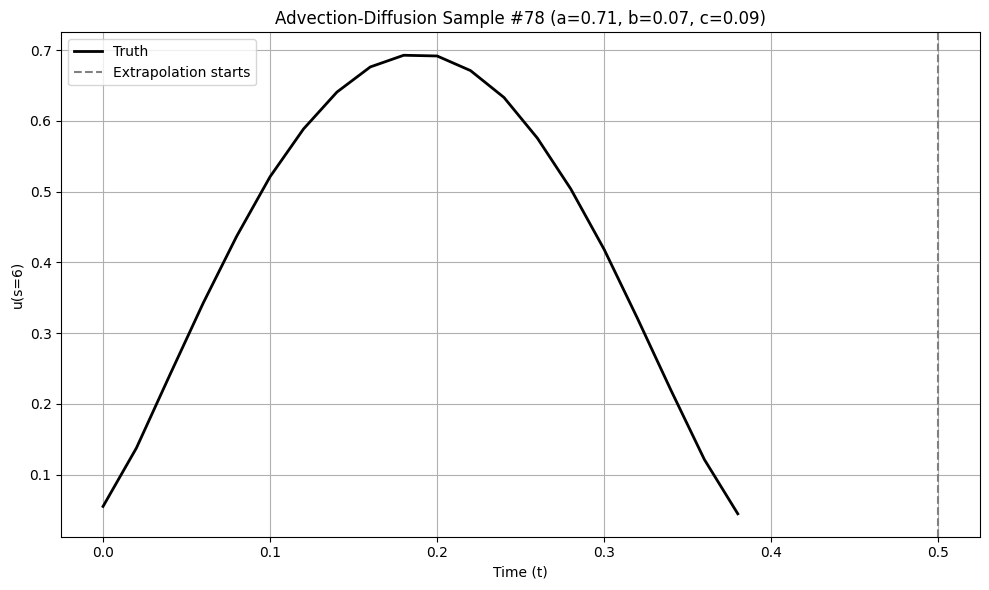

In [28]:
# data_test = np.load('./data/advdif/data_test.npy')  # (1000, 50, 12)
# params = np.loadtxt('./data/advdif/true_params_test.txt')  # (1000, 3)
# variant_dirs = {
#     "Phys-only": "./out_advdif_physonly/",
#     "NN+solver": "./out_advdif_nnonly1/",
#     "NN+phys+reg": "./out_advdif_physnn/",
# }

# plot_advdif_sample(idx=78, data_test=data_test, params=params, variant_dirs=variant_dirs)


In [30]:
import os

print("Phys-only:", os.listdir('./out_advdif_physonly'))
print("NN+solver:", os.listdir('./out_advdif_nnonly1'))
print("NN+phys+reg:", os.listdir('./out_advdif_physnn'))


Phys-only: ['args.json', 'log.txt', 'model.pt']
NN+solver: ['args.json', 'log.txt', 'model.pt']
NN+phys+reg: ['args.json', 'log.txt', 'model.pt']


In [32]:
# import os
# import json
# import numpy as np
# import torch
# from physvae.advdif.model import VAE

# device = "cpu"  # use "cuda" if GPU is available

# # Paths to model outputs
# variant_dirs = {
#     "Phys-only": "./out_advdif_physonly",
#     "NN+solver": "./out_advdif_nnonly1",
#     "NN+phys+reg": "./out_advdif_physnn"
# }

# # Load test data
# datadir = './data/advdif'
# data_test = np.load(f'{datadir}/data_test.npy')  # shape: (N, T, 12)
# N, T, X = data_test.shape

# # Dictionary to store predictions
# predictions = {}

# for name, modeldir in variant_dirs.items():
#     # Load args.json
#     with open(os.path.join(modeldir, 'args.json'), 'r') as f:
#         args_tr_dict = json.load(f)

#     # Instantiate and load model
#     model = VAE(args_tr_dict).to(device)
#     model.load_state_dict(torch.load(os.path.join(modeldir, 'model.pt'), map_location=device))
#     model.eval()

#     # Load model settings
#     dim_x = args_tr_dict['dim_x']
#     dim_t = args_tr_dict['dim_t']
#     dx = args_tr_dict['dx']
#     dt = args_tr_dict['dt']

#     # Prepare test data tensor
#     data_tensor = torch.Tensor(data_test).to(device).view(-1, dim_x, dim_t)

#     # Encode and sample latent variables
#     with torch.no_grad():
#         z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
#         z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat, hard_z=False)

#         # Setup extrapolation length
#         model.len_intg = (T - 1) * model.intg_lev + 1
#         model.t_intg = torch.linspace(0.0, model.dt_intg * (model.len_intg - 1), model.len_intg)

#         # Decode full trajectory from initial condition
#         init_y = data_tensor[:, :, 0].clone()
#         x_full, _, _, _, _ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

#     predictions[name] = x_full.cpu().numpy()  # shape: (N, dim_x, T_full)

# # Add ground truth to predictions (transpose for shape consistency)
# predictions["Truth"] = data_test.transpose(0, 2, 1)  # (N, X, T)


In [56]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Load ground truth data
# data_test = np.load('./data/advdif/data_test.npy')  # shape: (N, 20, T)
# dt = 0.02
# T_full = 600
# idx = 78  # sample index

# # If data only has 50 time steps, this will error.
# assert data_test.shape[2] >= T_full, "Ground truth does not have enough time steps."

# # Extract the sample
# truth = data_test[idx, :, :T_full]  # shape: (space, time)
# time = np.arange(T_full) * dt

# # Plot
# plt.figure(figsize=(6, 1.5))
# plt.imshow(truth, aspect='auto', origin='lower',
#            extent=[0, time[-1], 0, truth.shape[0]],
#            cmap='magma', interpolation='none', vmin=0, vmax=1)
# plt.axvline(x=dt * 25, color='white', linestyle='--', linewidth=1.2)
# plt.xlabel('Time $t$')
# plt.ylabel('Space')
# plt.title('Ground Truth: Advection–Diffusion Sample #78')
# plt.tight_layout()
# plt.show()


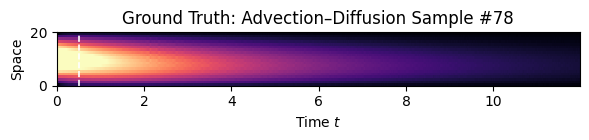

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Load long ground truth (600 steps)
data_test = np.load('./data/advdif/data_test600.npy')  # shape: (1000, 20, 600)
dt = 0.02
idx = 78  # sample index

# Extract and plot
truth = data_test[idx, :, :]  # shape: (space=20, time=600)
time = np.arange(truth.shape[1]) * dt

plt.figure(figsize=(6, 1.5))
plt.imshow(truth, aspect='auto', origin='lower',
           extent=[0, time[-1], 0, truth.shape[0]],
           cmap='magma', interpolation='none', vmin=0, vmax=1)
plt.axvline(x=dt * 25, color='white', linestyle='--', linewidth=1.2)
plt.xlabel('Time $t$')
plt.ylabel('Space')
plt.title('Ground Truth: Advection–Diffusion Sample #78')
plt.tight_layout()
plt.show()


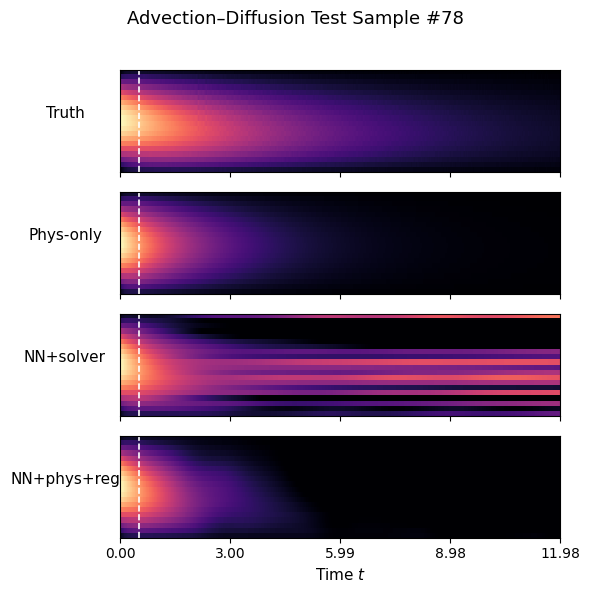

In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
from physvae.advdif.model import VAE

def load_model_prediction(model_dir, short_input, device='cpu'):
    with open(f'{model_dir}/args.json', 'r') as f:
        args = json.load(f)

    model = VAE(args).to(device)
    model.load_state_dict(torch.load(f'{model_dir}/model.pt', map_location=device))
    model.eval()

    intg_lev = args['intg_lev']
    dt = args['dt']

    with torch.no_grad():
        z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(short_input)
        z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat, hard_z=False)

    model.len_intg = (600 - 1) * intg_lev + 1
    model.t_intg = torch.linspace(0.0, dt * (model.len_intg - 1), model.len_intg)

    with torch.no_grad():
        init_y = short_input[:, :, 0].clone()
        x_full, *_ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

    return x_full.cpu().numpy()


def prepare_all_predictions(idx=78):
    # Load long ground truth (600 steps)
    data_truth = np.load('./data/advdif/data_test600.npy')
    short_input = torch.Tensor(data_truth[:, :, :50]).to("cpu")

    preds = {
        "Truth": data_truth,
        "Phys-only": load_model_prediction("./out_advdif_physonly", short_input),
        "NN+solver": load_model_prediction("./out_advdif_nnonly1", short_input),
        "NN+phys+reg": load_model_prediction("./out_advdif_physnn", short_input),
    }

    return preds


def plot_all(preds, idx=78, T_train=25, dt=0.02):
    methods = ["Truth", "Phys-only", "NN+solver", "NN+phys+reg"]
    T = preds["Truth"].shape[2]
    time = np.arange(T) * dt

    vmax = preds["Truth"][idx].max()

    fig, axes = plt.subplots(len(methods), 1, figsize=(6, 6), sharex=True, sharey=True)
    for i, method in enumerate(methods):
        ax = axes[i]
        arr = preds[method][idx]
        ax.imshow(arr, aspect='auto', origin='lower',
                  extent=[0, time[-1], 0, arr.shape[0]],
                  cmap='magma', interpolation='none',
                  vmin=0.0, vmax=vmax)
        ax.axvline(T_train * dt, color='white', linestyle='--', linewidth=1.2)
        ax.set_yticks([])
        ax.set_ylabel(method, rotation=0, labelpad=40, fontsize=11)
        ax.set_xticks([])

    axes[-1].set_xticks(np.linspace(0, time[-1], 5))
    axes[-1].set_xlabel('Time $t$', fontsize=11)
    plt.suptitle(f"Advection–Diffusion Test Sample #{idx}", fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# === Run ===
preds = prepare_all_predictions(idx=78)
plot_all(preds, idx=78)


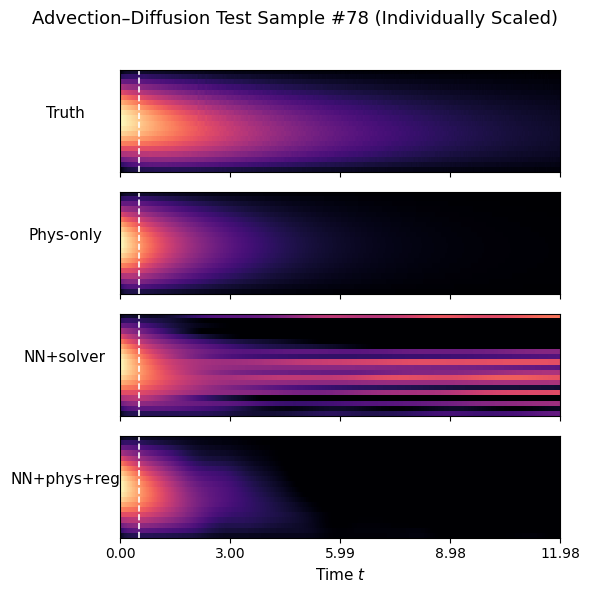

In [64]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
from physvae.advdif.model import VAE

def load_model_prediction(model_dir, short_input, device='cpu'):
    with open(f'{model_dir}/args.json', 'r') as f:
        args = json.load(f)

    model = VAE(args).to(device)
    model.load_state_dict(torch.load(f'{model_dir}/model.pt', map_location=device))
    model.eval()

    intg_lev = args['intg_lev']
    dt = args['dt']

    with torch.no_grad():
        z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(short_input)
        z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat, hard_z=False)

    model.len_intg = (600 - 1) * intg_lev + 1
    model.t_intg = torch.linspace(0.0, dt * (model.len_intg - 1), model.len_intg)

    with torch.no_grad():
        init_y = short_input[:, :, 0].clone()
        x_full, *_ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

    return x_full.cpu().numpy()


def prepare_all_predictions(idx=78):
    # Load long ground truth (600 steps)
    data_truth = np.load('./data/advdif/data_test600.npy')
    short_input = torch.Tensor(data_truth[:, :, :50]).to("cpu")

    preds = {
        "Truth": data_truth,
        "Phys-only": load_model_prediction("./out_advdif_physonly", short_input),
        "NN+solver": load_model_prediction("./out_advdif_nnonly1", short_input),
        "NN+phys+reg": load_model_prediction("./out_advdif_physnn", short_input),
    }

    return preds


def plot_all(preds, idx=78, T_train=25, dt=0.02):
    methods = ["Truth", "Phys-only", "NN+solver", "NN+phys+reg"]
    T = preds["Truth"].shape[2]
    time = np.arange(T) * dt

    fig, axes = plt.subplots(len(methods), 1, figsize=(6, 6), sharex=True, sharey=True)
    for i, method in enumerate(methods):
        ax = axes[i]
        arr = preds[method][idx]
        vmax_local = np.max(arr)

        ax.imshow(arr, aspect='auto', origin='lower',
                  extent=[0, time[-1], 0, arr.shape[0]],
                  cmap='magma', interpolation='none',
                  vmin=0.0, vmax=vmax_local)

        ax.axvline(T_train * dt, color='white', linestyle='--', linewidth=1.2)
        ax.set_yticks([])
        ax.set_ylabel(method, rotation=0, labelpad=40, fontsize=11)
        ax.set_xticks([])

    axes[-1].set_xticks(np.linspace(0, time[-1], 5))
    axes[-1].set_xlabel('Time $t$', fontsize=11)
    plt.suptitle(f"Advection–Diffusion Test Sample #{idx} (Individually Scaled)", fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# === Run ===
preds = prepare_all_predictions(idx=78)
plot_all(preds, idx=78)
